In [1]:
import random
import numpy as np
import torch
import torch.nn as nn #network 函式
import torch.nn.functional as F #一些方法
import torch.optim as optim #優化方法
from torchvision import datasets, transforms #提供資料集 演算法
import matplotlib.pyplot as plt #圖表
from PIL import Image, ImageFilter, ImageOps

In [2]:
### 資料前處理 ###
import os
import shutil

data_path = os.listdir('C:/Users/bymin/OneDrive/桌面/pytorch/hiragana-dataset-master/hiragana_images') #定義data_path
for i in data_path: #對data_path裡所有資料
    label = i.replace(".jpg","").strip('0123456789') #把label掐頭去尾
    if not os.path.exists('C:/Users/bymin/OneDrive/桌面/pytorch/hiragana-dataset-master/process'): #製作 process 資料夾，存放資料分類
        os.mkdir('C:/Users/bymin/OneDrive/桌面/pytorch/hiragana-dataset-master/process')
        
    data = 'C:/Users/bymin/OneDrive/桌面/pytorch/hiragana-dataset-master/process/'+ label
    if not os.path.exists(data): #找這label的資料夾是否存在 否則新增資料夾
        os.mkdir(data)
        
    data_src = 'C:/Users/bymin/OneDrive/桌面/pytorch/hiragana-dataset-master/hiragana_images/' + i 
    data_copy =  data + "/" + i
    shutil.copy(data_src, data_copy) #複製資料

In [3]:
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

##超參數
batch_size = 32 #批次大小
lr = 0.001 #學習率
num_epochs = 10 #代數

2.5.1+cu124
cuda


In [4]:
class AddGaussianNoise(object):
    """在影像中加入高斯雜訊
    
    參數:
        mean (float): 高斯雜訊的均值
        std  (float): 高斯雜訊的標準差
        p    (float): 有多大機率對影像做此增強
    """
    def __init__(self, mean=0., std=1., p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, img):
        if random.random() < self.p: # 先以機率 p 判斷要不要施加雜訊
            if isinstance(img, Image.Image): # 轉成 Tensor (若原本還是 PIL Image)
                img = transforms.ToTensor()(img)  # shape: [C, H, W]
            noise = torch.randn(img.size()) * self.std + self.mean # 加入高斯雜訊
            img = img + noise
            img = torch.clamp(img, 0., 1.) # clip 到 [0,1] 區間，確保像素值合理 (可依需求調整)
            img = transforms.ToPILImage()(img) # 若需要再轉回 PIL 就執行
        return img

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std}, p={self.p})"
    
class Addblur(object):
    def __init__(self, p=0.5,blur="normal"):
        #  self.density = density
        self.p = p
        self.blur= blur

    def __call__(self, img):
        if random.uniform(0, 1) < self.p:  # 概率的判断
       		#標準模糊
            if self.blur== "normal":
                img = img.filter(ImageFilter.BLUR)
                return img
            #高斯模糊
            if self.blur== "Gaussian":
                img = img.filter(ImageFilter.GaussianBlur)
                return img
            #均值模糊
            if self.blur== "mean":
                img = img.filter(ImageFilter.BoxBlur)
                return img
        else:
            return img
        
class InvertColors(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:# 若隨機數小於 p 則反轉顏色
            img = ImageOps.invert(img) # 若是灰階或 RGB，直接反轉
        return img

    def __repr__(self):
        return f"{self.__class__.__name__}(p={self.p})"


In [5]:
from sklearn.model_selection import train_test_split
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((64,64)), #
    transforms.ToTensor(),  # shape H，W，C —> C，H，W
    transforms.Normalize((0.1307,), (0.3081,)) # 將資料壓縮至一個範圍，例如：-1,1，這樣跑的效率會比較高
])

transformAddNoices = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((64,64)), #
    AddGaussianNoise(mean=0., std=0.3, p=1),
    transforms.ToTensor(),  # shape H，W，C —> C，H，W
    transforms.Normalize((0.1307,), (0.3081,)) # 將資料壓縮至一個範圍，例如：-1,1，這樣跑的效率會比較高
])

transformAddBlur = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((64,64)), #
    Addblur(p=1,blur="Gaussian"),
    transforms.ToTensor(),  # shape H，W，C —> C，H，W
    transforms.Normalize((0.1307,), (0.3081,)) # 將資料壓縮至一個範圍，例如：-1,1，這樣跑的效率會比較高
])

transformColoeRev = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((64,64)), #
    InvertColors(p=1), 
    transforms.ToTensor(),  # shape H，W，C —> C，H，W
    transforms.Normalize((0.1307,), (0.3081,)) # 將資料壓縮至一個範圍，例如：-1,1，這樣跑的效率會比較高
])

datasetA = datasets.ImageFolder(root='C:/Users/bymin/OneDrive/桌面/pytorch/hiragana-dataset-master/process', transform=transform) #使用ImageFolder加載資料集
datasetB = datasets.ImageFolder(root='C:/Users/bymin/OneDrive/桌面/pytorch/hiragana-dataset-master/process', transform=transformAddNoices) #使用ImageFolder加載資料集 套用高斯噪點
datasetC = datasets.ImageFolder(root='C:/Users/bymin/OneDrive/桌面/pytorch/hiragana-dataset-master/process', transform=transformAddBlur) #使用ImageFolder加載資料集 套用模糊
datasetD = datasets.ImageFolder(root='C:/Users/bymin/OneDrive/桌面/pytorch/hiragana-dataset-master/process', transform=transformColoeRev) #使用ImageFolder加載資料集 套用模糊
dataset = torch.utils.data.ConcatDataset([datasetA, datasetB, datasetC, datasetD])
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42) #sklearn分割資料集 train:test 8:2 random_state=42：設定隨機種子，保證每次分割的結果一致。
print(len(train_data), len(test_data))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True) #shuffle=True 隨機打散資料集
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

label_dict = datasetA.class_to_idx #生出 label:index 的字典
reverse_label_dict = {v: k for k, v in label_dict.items()} #原始字典 label_dict 的key值對交換後生成一個新的字典 reverse_label_dict
print(reverse_label_dict)


3200 800
{0: 'kanaA', 1: 'kanaBA', 2: 'kanaCHI', 3: 'kanaDA', 4: 'kanaE', 5: 'kanaFU', 6: 'kanaHA', 7: 'kanaHE', 8: 'kanaHI', 9: 'kanaHO', 10: 'kanaI', 11: 'kanaJI', 12: 'kanaKA', 13: 'kanaKE', 14: 'kanaKI', 15: 'kanaKO', 16: 'kanaKU', 17: 'kanaMA', 18: 'kanaME', 19: 'kanaMI', 20: 'kanaMO', 21: 'kanaMU', 22: 'kanaN', 23: 'kanaNA', 24: 'kanaNE', 25: 'kanaNI', 26: 'kanaNO', 27: 'kanaNU', 28: 'kanaO', 29: 'kanaPI', 30: 'kanaRA', 31: 'kanaRE', 32: 'kanaRI', 33: 'kanaRO', 34: 'kanaRU', 35: 'kanaSA', 36: 'kanaSE', 37: 'kanaSHI', 38: 'kanaSO', 39: 'kanaSU', 40: 'kanaTA', 41: 'kanaTE', 42: 'kanaTO', 43: 'kanaTSU', 44: 'kanaU', 45: 'kanaWA', 46: 'kanaWO', 47: 'kanaYA', 48: 'kanaYO', 49: 'kanaYU'}


In [6]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(256*6*6, 512) #第一層全連接層 輸入256*8*8 輸出512
        self.fc2 = nn.Linear(512, 50) #第二層全連接層 輸入512 輸出50個類別
        
    def forward(self, x): #
        x = self.pool(F.relu(self.conv1(x))) # 卷積 -> sigmoid -> 池化 84 -> conv1 -> 82 -> pool -> 41
        x = self.pool(F.relu(self.conv2(x))) # 41 -> conv2 -> 39 -> pool -> 19
        x = self.pool(F.relu(self.conv3(x))) # 19 -> conv3 -> 17 -> pool -> 8
        # print(x.shape) #此時x.shape = (batch_size, 256, 8, 8)
        x = x.view(-1, 256*6*6) #圖像攤平成一個向量 (batch_size, 256個維度*(8*8)個像素) -1讓 PyTorch 自動推斷 batch 大小
        x = F.relu(self.fc1(x)) #將x 丟進fc1後 應用relu激活函數
        x = self.fc2(x) #將x丟進fc2
        
        return x #這邊輸出x不做softmax的訓練結果較好
    
model = Cnn()
model = model.to(device)
print(model)

## 優化器
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)

# criterion = nn.MSELoss().to(device)
# criterion = nn.L1Loss().to(device)
# criterion = nn.BCELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)  #交叉商

Cnn(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=50, bias=True)
)


### resnet 

In [7]:
def accuracy(pred: torch.Tensor, label: torch.Tensor):
  
  _, pred_label = pred.max(1) # pred.max(1) 取得每筆資料預測機率最高的類別索引
  num_correct = (pred_label == label).sum().item() 
  acc = num_correct / label.shape[0] # 準確度 = 正確預測數量 / 總樣本數
  return acc


metric = {'loss': [], 'acc': []}
for i_epoch in range(num_epochs):
  train_loss = [] #宣告train的loss
  train_acc = [] #宣告train的acc
  model.train(mode=True) #模型轉為訓練模式
  for i_batch, (image, label) in enumerate(train_loader): #迭代每個batch 
    image = image.to(device) #圖片丟進gpu
    # print(image.shape)
    # print(label.min(), label.max())
    label = label.to(device) #label丟進gpu

    pred = model.forward(image) #預測pred 將圖片丟進模型 模型輸出的(未經 softmax) 形狀(batch_size, num_classes)
    loss = criterion(pred, label) #使用 CrossEntropyLoss，計算此次 batch 的 loss，將 pred 與 label 做比較

    optimizer.zero_grad()  #上一輪的梯度歸零
    loss.backward() # 反向傳播 計算梯度
    optimizer.step() #optimizer進行參數更新

    train_loss += [loss.item()] #將該 batch 的損失記錄到 train_loss 清單
    train_acc += [accuracy(pred, label)] #計算該 batch 的準確度，並記錄到 train_acc 清單
  metric['loss'] += [sum(train_loss)/ len(train_loader)] #統計當前 epoch 所有 batch 的平均 loss
  metric['acc'] += [sum(train_acc)/ len(train_loader)] #統計當前 epoch 所有 batch 的平均 acc
  print(f'Epoch[{i_epoch+1}/{num_epochs}] loss: {metric["loss"][-1]}, acc: {metric["acc"][-1]}')

Epoch[1/10] loss: 1.8410458939522505, acc: 0.5303125
Epoch[2/10] loss: 0.10134735882980749, acc: 0.97375
Epoch[3/10] loss: 0.03402058560168371, acc: 0.9896875
Epoch[4/10] loss: 0.013112584508198778, acc: 0.9971875
Epoch[5/10] loss: 0.013549964509220445, acc: 0.9959375
Epoch[6/10] loss: 0.019817813357512933, acc: 0.9965625
Epoch[7/10] loss: 0.026538779825277744, acc: 0.9925
Epoch[8/10] loss: 0.01886079987110861, acc: 0.994375
Epoch[9/10] loss: 0.03831870631678612, acc: 0.9896875
Epoch[10/10] loss: 0.05433442548470339, acc: 0.9846875


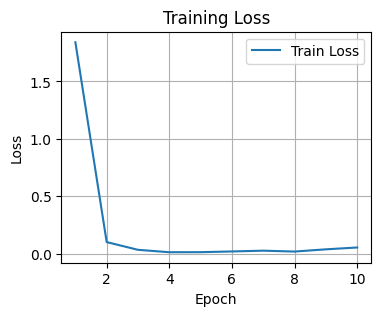

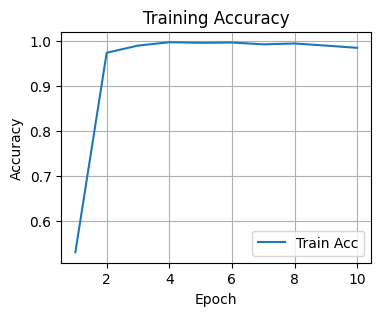

In [8]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs+1)

plt.figure(figsize=(4, 3))
plt.plot(epochs, metric['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(4, 3))
plt.plot(epochs, metric['acc'], label='Train Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for image, label in test_loader:
      image = image.to(device)
      label = label.to(device)
      pred = model.forward(image)
      _, pred_label = pred.max(1)
      total_correct += (pred_label == label).sum().item()
      total_samples += label.size(0)


print(f'Total correct: {total_correct}')
print(f'Total samples: {total_samples}')
test_acc = total_correct / total_samples
print(f'Test Accuracy: {test_acc}')

Total correct: 797
Total samples: 800
Test Accuracy: 0.99625


In [10]:
from pathlib import Path
model_path = Path('./models/model_try.pt') #模型儲存位置/檔名
model_path.parent.mkdir(parents=True, exist_ok=True)
torch.jit.script(model).save(model_path)
print("Saved")

Saved
